<a href="https://colab.research.google.com/github/savinthie/Final_Year_Project_IDP_2024-2025/blob/main/XGBOOST_CNN_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, ReLU, Concatenate, MaxPooling1D,Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/FYP 2024 25/USDataset.csv', header=1)
df = df.fillna(0)

Mounted at /content/drive


In [3]:
# Data Preprocessing
df.columns = [col.lower().replace(' ', '').replace('.', '') for col in df.columns]
cols_to_keep = ['stateabv', 'county', 'family', 'housing', 'food', 'transportation',
                'healthcare', 'othernecessities', 'childcare', 'taxes', 'total',
                'median_family_income', 'num_counties_in_st']
df1 = df[cols_to_keep].copy()

df1['median_family_income'] = df1['median_family_income'].replace(',', '', regex=True).astype(float)

In [4]:
# Feature Engineering
df1['n_parents'] = df1['family'].str.slice(0, 1).astype(int)
df1['n_children'] = df1['family'].str.slice(2, 3).astype(int)
df1['n_members'] = df1['n_parents'] + df1['n_children']
df1['financial_stability'] = df1['median_family_income'] / df1['total']
df1["per_member_cost"] = df1["total"] / df1["n_members"]
df1["child_expense_cost"] = df1["per_member_cost"]*df1["n_children"]
df1["parent_expense_cost"] = df1["per_member_cost"]*df1["n_parents"]
df1["other_expense_cost"] = df1["total"] - (df1["child_expense_cost"]+df1["parent_expense_cost"])

In [5]:
# Splitting the data
X = df1[['total', 'median_family_income', 'num_counties_in_st', 'n_children', 'n_parents', 'n_members']+['per_member_cost','child_expense_cost','parent_expense_cost','other_expense_cost']].values
y_expenses = df1[['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']].values

target_col_list = ['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']

# Scaling
scaler_X = StandardScaler()

# Load the X scaler
# scaler_X = joblib.load('scaler_X.pkl')

X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()

# Load the y scaler
# scaler_y = joblib.load('scaler_y.pkl')
y_exp_scaled = scaler_y.fit_transform(y_expenses)



# Save the X scaler
joblib.dump(scaler_X, 'scaler_X.pkl')

# Save the y scaler
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [6]:
# Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=100)

# Metrics
def print_metrics(y_true, y_pred, task_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{task_name} - MSE: {mse:.4f}, R2: {r2:.4f}")

def regr_report(x, y):
    mae = round(mean_absolute_error(x, y), 4)
    r2 = round(r2_score(x, y), 4)
    mse = round(mean_squared_error(x, y), 4)
    rmse = round(np.sqrt(mean_squared_error(x, y)), 4)
    return f'MAE: {mae}, R-Squared: {r2}, RMSE: {rmse}, MSE: {mse}'

In [7]:
from tensorflow.keras.layers import Input, Conv1D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# L2 regularization strength (you can tune this value)
l2_strength = 0.01

# Hybrid model setup
def create_hybrid_model(input_shape, output_shape):
    input_layer = Input(shape=input_shape)

    # CNN part with Dropout and L2 Regularization
    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',
               kernel_regularizer=l2(l2_strength))(input_layer)  # L2 Regularization
    x = Dropout(0.2)(x)  # Dropout after the convolutional layer
    x = Flatten()(x)

    # ANN part with Dropout and L2 Regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(x)
    x = Dropout(0.2)(x)  # Dropout after first dense layer
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_strength))(x)
    x = Dropout(0.3)(x)  # Dropout after second dense layer
    x = Dense(32, activation='relu', kernel_regularizer=l2(l2_strength))(x)
    x = Dropout(0.3)(x)  # Dropout after third dense layer

    # Output layers
    output_layers = [Dense(1, activation='linear', name=f'target_{col}')(x) for col in target_col_list]

    model = Model(inputs=input_layer, outputs=output_layers)

    return model

In [8]:
import xgboost as xgb
def create_xgboost_model(X_train, y_train):
    # Reshape X_train to 2D for XGBoost
    X_train_2d = X_train.reshape(X_train.shape[0], -1)  # Reshape to 2D
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1)
    xg_reg.fit(X_train_2d, y_train) # Use reshaped data for fitting
    return xg_reg

Fold 1/5
Epoch 1/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.5462 - target_childcare_loss: 0.6361 - target_food_loss: 0.5490 - target_healthcare_loss: 0.6735 - target_housing_loss: 0.7273 - target_othernecessities_loss: 0.5500 - target_taxes_loss: 0.6925 - target_transportation_loss: 0.8035 - val_loss: 2.4071 - val_target_childcare_loss: 0.1674 - val_target_food_loss: 0.0685 - val_target_healthcare_loss: 0.2307 - val_target_housing_loss: 0.2190 - val_target_othernecessities_loss: 0.0797 - val_target_taxes_loss: 0.1201 - val_target_transportation_loss: 0.4003
Epoch 2/400
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0057 - target_childcare_loss: 0.2844 - target_food_loss: 0.1883 - target_healthcare_loss: 0.3309 - target_housing_loss: 0.3196 - target_othernecessities_loss: 0.1952 - target_taxes_loss: 0.2415 - target_transportation_loss: 0.4738 - val_loss: 1.7951 - val_target_childcare_loss: 0.1335 - val_target_food_loss: 0.0567 - val_target_healthcare_loss: 0.2134 - val_t

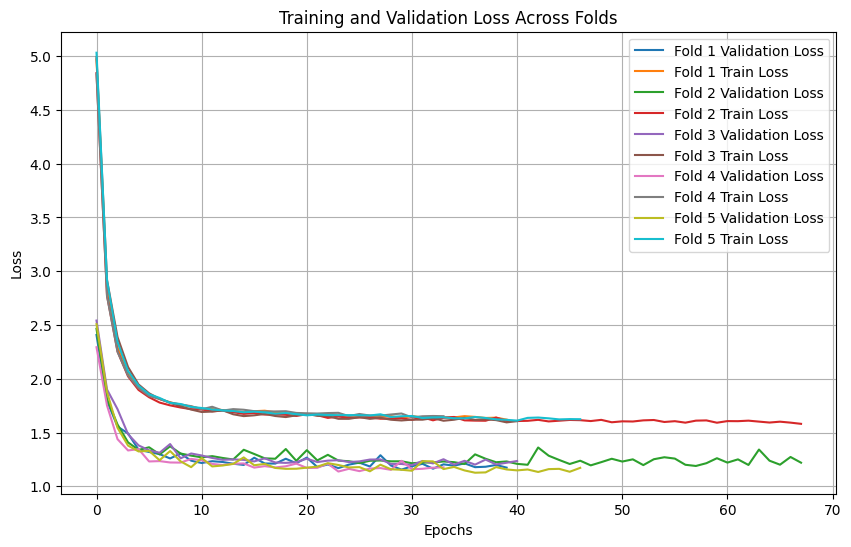

In [9]:
import matplotlib.pyplot as plt

# Cross-Validation with Evaluation and Training/Validation Loss Curve
def cross_val_with_evaluation(X_scaled, y_exp_scaled, kf, num_epochs=400):
    fold = 1

    # To store metrics across all folds
    metrics_summary = {target: {'train': [], 'val': [], 'test': []} for target in target_col_list}

    # To store loss values for each fold
    all_train_loss = []
    all_val_loss = []

    for train_index, val_index in kf.split(X_scaled):
        print(f"Fold {fold}/{kf.get_n_splits()}")
        X_train, X_test_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_test_val = y_exp_scaled[train_index], y_exp_scaled[val_index]

        # 50/50 split of remaining 20% for test and validation sets
        X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=100)

        # Reshaping data for CNN
        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1,
            mode='min',
            restore_best_weights=True
        )

        # Create and compile the model
        model = create_hybrid_model((X_train.shape[1], 1), y_train.shape[1])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # Training
        history = model.fit(
            X_train, [y_train[:, i] for i in range(y_train.shape[1])],
            validation_data=(X_val, [y_val[:, i] for i in range(y_val.shape[1])]),
            epochs=num_epochs,
            batch_size=128,
            verbose=1,
            callbacks=[early_stopping]
        )

        # Store loss values for the current fold
        all_train_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        # Predictions for hybrid model
        y_train_pred = np.column_stack(model.predict(X_train))
        y_val_pred = np.column_stack(model.predict(X_val))
        y_test_pred = np.column_stack(model.predict(X_test))  # Prediction on test set

        #Create XGBoost regressor
        xgboost_models = []
        for i in range(y_train.shape[1]):
            xg_model = create_xgboost_model(X_train, y_train[:, i])
            xgboost_models.append(xg_model)

        # Predictions from each XGBoost model
        y_train_xgb_pred = np.column_stack([model.predict(X_train.reshape(X_train.shape[0], -1)) for model in xgboost_models])
        y_val_xgb_pred = np.column_stack([model.predict(X_val.reshape(X_val.shape[0], -1)) for model in xgboost_models])
        y_test_xgb_pred = np.column_stack([model.predict(X_test.reshape(X_test.shape[0], -1)) for model in xgboost_models])

        # Combine predictions
        y_train_pred = (y_train_pred + y_train_xgb_pred) / 2
        y_val_pred = (y_val_pred + y_val_xgb_pred) / 2
        y_test_pred = (y_test_pred + y_test_xgb_pred) / 2


        # Inverse scaling
        y_train_pred_original = scaler_y.inverse_transform(y_train_pred)
        y_train_original = scaler_y.inverse_transform(y_train)
        y_val_pred_original = scaler_y.inverse_transform(y_val_pred)
        y_val_original = scaler_y.inverse_transform(y_val)
        y_test_pred_original = scaler_y.inverse_transform(y_test_pred)  # Inverse transform for test set
        y_test_original = scaler_y.inverse_transform(y_test)  # Inverse transform for test set

        # Metrics for each target and accumulate results
        for i, target in enumerate(target_col_list):
            print(f'Model Results for {target.capitalize()} (Fold {fold}):')
            train_metrics = regr_report(y_train_original[:, i], y_train_pred_original[:, i])
            val_metrics = regr_report(y_val_original[:, i], y_val_pred_original[:, i])
            test_metrics = regr_report(y_test_original[:, i], y_test_pred_original[:, i])

            # Store metrics for this fold
            metrics_summary[target]['train'].append(train_metrics)
            metrics_summary[target]['val'].append(val_metrics)
            metrics_summary[target]['test'].append(test_metrics)

            print('Train Data:', train_metrics)
            print('Validation Data:', val_metrics)
            print('Test Data:', test_metrics)
            print()

        fold += 1

    # Compute and display final average metrics across all folds
    print("Final Average Metrics After 5 Folds:")
    for target in target_col_list:
        print(f"Results for {target.capitalize()}:")

        # Modified to calculate average metrics from numerical values
        train_metrics_df = pd.DataFrame([eval(x.replace('MAE: ', '').replace('R-Squared: ', '').replace('RMSE: ', '').replace('MSE: ', '').replace(', ', ',')) for x in metrics_summary[target]['train']], columns=['MAE', 'R-Squared', 'RMSE', 'MSE'])
        avg_train_metrics = train_metrics_df.mean().to_dict()

        val_metrics_df = pd.DataFrame([eval(x.replace('MAE: ', '').replace('R-Squared: ', '').replace('RMSE: ', '').replace('MSE: ', '').replace(', ', ',')) for x in metrics_summary[target]['val']], columns=['MAE', 'R-Squared', 'RMSE', 'MSE'])
        avg_val_metrics = val_metrics_df.mean().to_dict()

        test_metrics_df = pd.DataFrame([eval(x.replace('MAE: ', '').replace('R-Squared: ', '').replace('RMSE: ', '').replace('MSE: ', '').replace(', ', ',')) for x in metrics_summary[target]['test']], columns=['MAE', 'R-Squared', 'RMSE', 'MSE'])
        avg_test_metrics = test_metrics_df.mean().to_dict()

        print("Average Train Metrics:", avg_train_metrics)
        print("Average Validation Metrics:", avg_val_metrics)
        print("Average Test Metrics:", avg_test_metrics)
        print()

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    for i, (train_loss, val_loss) in enumerate(zip(all_train_loss, all_val_loss)):
        plt.plot(val_loss, label=f'Fold {i + 1} Validation Loss')
        plt.plot(train_loss, label=f'Fold {i + 1} Train Loss')


    plt.title("Training and Validation Loss Across Folds")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# Cross-Validation Execution
model = cross_val_with_evaluation(X_scaled, y_exp_scaled, kf)
model.save_weights("model_expenses.weights.h5")


In [10]:
def get_prediction(model, input_data):
    input_data_val = input_data.values
    input_data_val_scaled = scaler_X.fit_transform(input_data_val)
    input_data_val_scaled = input_data_val_scaled[..., np.newaxis]
    input_data_pred = np.column_stack(model.predict(input_data_val_scaled))
    input_data_pred_original = scaler_y.inverse_transform(input_data_pred)
    return input_data_pred_original

In [11]:
import pandas as pd
import numpy as np

input_data = pd.DataFrame(
    [[7000, 40000, 50, 2, 0, 1]],
    columns=['total', 'median_family_income', 'num_counties_in_st', 'n_children', 'n_parents', 'n_members']
)

input_data["per_member_cost"] = input_data["total"] / input_data["n_members"]
input_data["child_expense_cost"] = input_data["per_member_cost"] * input_data["n_children"]
input_data["parent_expense_cost"] = input_data["per_member_cost"] * input_data["n_parents"]
input_data["other_expense_cost"] = input_data["total"] - (input_data["child_expense_cost"] + input_data["parent_expense_cost"])

input_data_pred_original = get_prediction(model, input_data)


# Print predictions with labels
target_col_list = ['housing', 'food', 'transportation', 'healthcare', 'othernecessities', 'childcare', 'taxes']
for i, prediction in enumerate(input_data_pred_original[0]):
    print(f"{target_col_list[i]}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
housing: 983.9389038085938
food: 804.0376586914062
transportation: 1601.7923583984375
healthcare: 1143.564697265625
othernecessities: 632.7941284179688
childcare: 1076.3348388671875
taxes: 862.8182983398438
